In [ ]:
# Installation of FEniCS in Colab via
try:
    import dolfin
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenics-install.sh" -O "/tmp/fenics-install.sh" && bash "/tmp/fenics-install.sh"
    import dolfin

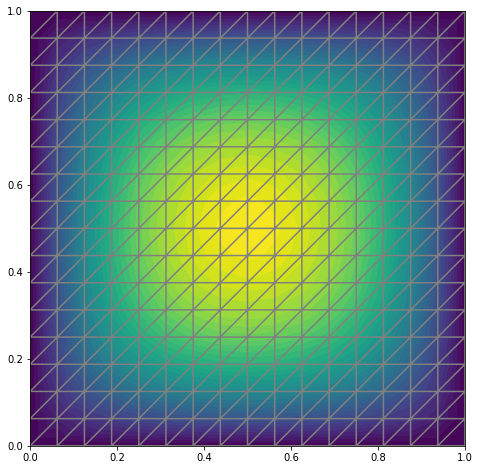

In [8]:
# Example 1: Solve 2D Poisson problem using energy minimization
from dolfin import *
from pylab import plt

# Create mesh and define function space and bc
mesh = UnitSquareMesh(16, 16)
W    = FunctionSpace(mesh, "CG", 1)
bc   = DirichletBC(W, Constant(0.0), 'on_boundary')

# Define function, test function, trial function and rhs f=1
w       = Function(W)
dw      = TestFunction(W)
f       = Constant(1.0)

# Define Energy E and Res=<DE(w),dw> and Jac=<DRes,delta_w>
E     = 0.5*inner(grad(w),grad(w))*dx - inner(f,w)*dx
Res   = derivative(E, w, dw)

# Solve DE=0          
solve(Res == 0, w, bc)   

# Plot solution
fig = plt.figure(figsize=(8,8))
plot(w)
plot(mesh)

# plt.savefig("example1.png",quality=100,dpi=600)


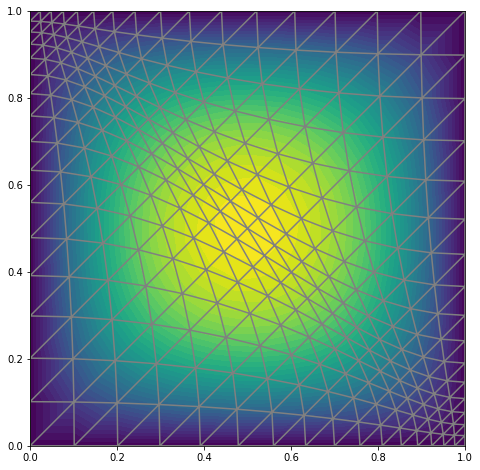

In [9]:
# Example 2: Solve 2D Poisson problem on mapped domain using energy minimization
from dolfin import *
from pylab import plt
import numpy as np

# Create mesh and define function space and bc
mesh = UnitSquareMesh(16, 16)
W    = FunctionSpace(mesh, "CG", 1)
bc   = DirichletBC(W, Constant(0.0), 'on_boundary')

map  = Expression(('0.2*sin(pi*x[0])*cos(pi*x[1])','0.2*cos(pi*x[0])*sin(pi*x[1])'),pi = np.pi, degree=2)
psi  = interpolate(map,VectorFunctionSpace(mesh, "CG", 1))

# Define function, test function, trial function and rhs f=1
w       = Function(W)
dw      = TestFunction(W)
f       = Constant(1.0)

I = Identity(2)
F = I + grad(psi)
J = det(F)

# Define Energy E and Res=<DE(w),dw> and Jac=<DRes,delta_w>
E     = 0.5*inner(inv(F).T*grad(w),inv(F).T*grad(w))*J*dx - inner(f,w)*J*dx
Res   = derivative(E, w, dw)

# Solve DE=0          
solve(Res == 0, w, bc)   

# Plot solution
fig = plt.figure(figsize=(8,8))
ALE.move(mesh,psi)
plot(w)
plot(mesh)

# plt.savefig("example2.png",quality=100,dpi=600)

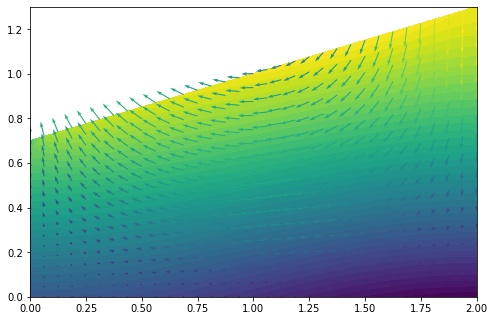

In [6]:
# Example 3: Solve Stokes problem with gravity using energy minimization
from dolfin import *
from pylab import plt
import numpy as np

# Create mesh and define function space
L     = Constant(2.0)
scale = Constant(0.3)
mesh = RectangleMesh(Point(0,0),Point(L,1),32,16,diagonal="right")

# Taylor-Hood element
P2 = VectorElement("Lagrange", mesh.ufl_cell(), 2) # P2 vector
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1) # P1 scalar
V  = FunctionSpace(mesh,P2*P1)

# Define boundary condition
def boundary_bottom(x, on_boundary):
    return near(x[1], 0.0)
def boundary_side(x, on_boundary):
    return near(x[0], 0.0) or near(x[0],L)

noslip = DirichletBC(V.sub(0), Constant((0.0,0.0)), boundary_bottom)
slip   = DirichletBC(V.sub(0).sub(0), Constant((0.0)), boundary_side)
bc     = [noslip,slip]

map  = Expression(('0','scale*(x[0]-L/2)*x[1]'),scale=scale,L=L, degree=2)
psi  = interpolate(map,VectorFunctionSpace(mesh, "CG", 1))
ALE.move(mesh,psi)

# Weak form of Stokes problem with f=(1,0) and solve
v       = Function(V)
dv      = TestFunction(V)

u,p     = split(v)
f   = Constant((0.0,1.0))

# Define Rayleighian: Dissipation + Constraint + DE
R     = 0.5 * ( inner(sym(grad(u)),sym(grad(u))) + p*div(u) + inner(f,u) )*dx
Res   = derivative(R, v, dv)

# Solve           
solve(Res == 0, v, bc)   

# Plot solution
(u, p) = v.split()
fig = plt.figure(figsize=(8,8))
plot(p)
plot(u)

# plt.savefig("example3.png",quality=100,dpi=600)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


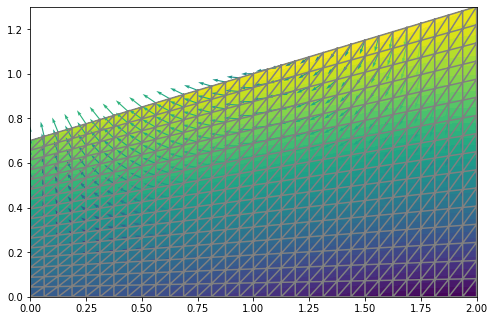

In [4]:
# Example 4: Solve Stokes FBP using incremental minimization (single step)
from dolfin import *
from pylab import plt
import numpy as np

# Create mesh and define function space
L     = Constant(2.0)
scale = Constant(0.3)
mesh = RectangleMesh(Point(0,0),Point(L,1),32,16,diagonal="right")

# Taylor-Hood element
P2 = VectorElement("Lagrange", mesh.ufl_cell(), 2) # P2 vector
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1) # P1 scalar
Q  = FunctionSpace(mesh,P2*P1)

# Define boundary condition
def boundary_bottom(x, on_boundary):
    return near(x[1], 0.0)
def boundary_side(x, on_boundary):
    return near(x[0], 0.0) or near(x[0],L)

noslip = DirichletBC(Q.sub(0), Constant((0.0,0.0)), boundary_bottom)
slip   = DirichletBC(Q.sub(0).sub(0), Constant((0.0)), boundary_side)
bc     = [noslip,slip]

map  = Expression(('0','scale*(x[0]-L/2)*x[1]'),scale=scale,L=L, degree=2)
psi  = interpolate(map,VectorFunctionSpace(mesh, "CG", 1))
ALE.move(mesh,psi)

# Simulation parameters
t       = 0.0
T       = 1.0
n_steps = 200
dt      = T/(n_steps)

# Initial data
q_old = interpolate(Expression(('0','0','0'), degree=2),Q)
w_old, p_old = split(q_old)

# Weak form of Stokes problem with f=(1,0) and solve
q       = Function(Q)
dq      = TestFunction(Q)
w,  p   = split(q)

I = Identity(2)
F = I + grad(w_old)
J = det(F)

dwdt = (w-w_old)/dt

f   = Constant((0.0,1.0))

# Define Rayleighian
R     = ( 0.5*dt*inner(sym(grad(dwdt)*inv(F)),sym(grad(dwdt)*inv(F))) + p*(det(I+grad(w))-1) + inner(f/J,w) )*J*dx
Res   = derivative(R, q, dq)

# Solve           
solve(Res == 0, q, bc)

# Plot solution
(w, p) = q.split()
fig = plt.figure(figsize=(8,8))
dwdt = (w - w_old)/dt
plot(p)
plot(dwdt)
plot(mesh)

In [ ]:
# Example 5: Solve Stokes FBP using incremental minimization (time stepping)
from dolfin import *
from pylab import plt
import numpy as np

# Create mesh and define function space
L     = Constant(2.0)
scale = Constant(0.3)
tol   = 1E-10

mesh = RectangleMesh(Point(0,0),Point(L,1),32*2,16*2,diagonal="right")

# Taylor-Hood element
P2 = VectorElement("Lagrange", mesh.ufl_cell(), 2) # P2 vector
P1 = FiniteElement("Lagrange", mesh.ufl_cell(), 1) # P1 scalar

Q  = FunctionSpace(mesh,P2*P1)
X  = FunctionSpace(mesh,P2)

W  = Q.sub(0)
P  = Q.sub(1)

# Define boundary condition
def boundary_bottom(x, on_boundary):
    return near(x[1], 0.0,tol)
def boundary_side(x, on_boundary):
    return near(x[0], 0.0,tol) or near(x[0],L,tol)

bottom = DirichletBC(W.sub(1), Constant((0.0)), boundary_bottom)
side   = DirichletBC(W.sub(0), Constant((0.0)), boundary_side)
bc     = [bottom,side]

map  = Expression(('0','scale*(x[0]-L/2)*x[1]'),scale=scale,L=L, degree=2)
psi  = interpolate(map,VectorFunctionSpace(mesh, "CG", 1))
ALE.move(mesh,psi)

# Incremental scheme for Stokes problem
def evolve(old_q, dt):
    old_w, old_p = split(old_q)

    q       = Function(Q)
    dq      = TestFunction(Q)
    deltaq  = TrialFunction(Q)

    w,  p   = split(q)

    I = Identity(2)
    F = I + grad(old_w)
    J = det(F)

    dwdt = (w-old_w)/dt
    x0   =  interpolate(Expression(('x[0]','x[1]'),degree=2),X)
    f    = Constant((0.0,1.0))

    # Define Rayleighian
    E     = inner(f,x0+w)*dx
    R     = 0.5*dt*inner(sym(grad(dwdt)*inv(F)),sym(grad(dwdt)*inv(F)))*J*dx + p*(det(I+grad(w))-1)*dx + E
    Res   = derivative(R, q, dq)
    Jac   = derivative(Res, q, deltaq)

    # Solve    
    q.assign(old_q)
    solve(Res == 0, q, bc, J=Jac)  
    energy = assemble(E)
    return q,energy

def output(q,old_q,t,dt):
    w, p = q.split()
    old_w, old_p = old_q.split()

    tmp  = Function(Q)
    dwdt = Function(Q)
    
    dwdt = project((w-old_w)/dt)

    w.rename('w', 'Displacement')
    p.rename('p', 'Pressure')
    dwdt.rename('u','Velocity')

    ALE.move(mesh, q.sub(0))
    file1 << (w, t)
    file2 << (p, t)
    file3 << (dwdt, t)
    tmp.assign(-q)
    ALE.move(mesh, tmp.sub(0))

# Simulation parameters
t       =    0.0
T       =   50.0
n_steps =    200
dt      = T/(n_steps)
old_q   = interpolate(Expression(('0','0','0'), degree=2),Q)

file1   = File('./output_slosh_viscous/displacement.pvd')
file2   = File('./output_slosh_viscous/pressure.pvd')
file3   = File('./output_slosh_viscous/velocity.pvd')

for i in range(n_steps+1):
    t += dt
    q,energy = evolve(old_q, dt)    
    output(q,old_q, t,dt)
    old_q.assign(q)
    print("iter: %d t: %4.1f e: %6.4f" % (i,t,energy))